In [1]:
# import libraries

import sys
import asyncio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable


import aiohttp
from prettytable import PrettyTable

from fpl import FPL

from sklearn.ensemble import RandomForestRegressor

In [2]:
# demo manual table build

async with aiohttp.ClientSession() as session:
    fpl = FPL(session)
    players = await fpl.get_players()

    top_performers = sorted(
        players, key=lambda x: x.goals_scored + x.assists, reverse=True)

    player_table = PrettyTable()
    player_table.field_names = ["Player", "£", "G", "A", "G + A", "PPG", "MINS", "COPNR", "PEN_MISSES", "SELECT_BY"]
    player_table.align["Player"] = "l"

    for player in top_performers[:5]:
        goals = player.goals_scored
        assists = player.assists
        ppg = player.total_points
        mins = player.minutes
        copnr = player.chance_of_playing_next_round
        pen_misses = player.penalties_missed
        select_by = player.selected_by_percent
        player_table.add_row([player.web_name, f"£{player.now_cost / 10}",
                            goals, assists, goals + assists, ppg, mins, copnr, pen_misses, select_by])

    print(player_table)

+-----------+-------+----+----+-------+-----+------+-------+------------+-----------+
| Player    |   £   | G  | A  | G + A | PPG | MINS | COPNR | PEN_MISSES | SELECT_BY |
+-----------+-------+----+----+-------+-----+------+-------+------------+-----------+
| Haaland   | £14.0 | 36 | 9  |   45  | 272 | 2767 |  None |     0      |    86.8   |
| Kane      | £12.5 | 30 | 9  |   39  | 263 | 3406 |  None |     1      |    11.8   |
| Salah     | £12.5 | 19 | 13 |   32  | 239 | 3290 |  None |     2      |    23.8   |
| Saka      |  £8.5 | 14 | 12 |   26  | 202 | 3183 |  None |     1      |    55.2   |
| De Bruyne | £10.5 | 7  | 18 |   25  | 183 | 2413 |  100  |     0      |    11.4   |
+-----------+-------+----+----+-------+-----+------+-------+------------+-----------+


In [3]:
# build dict from set list of fields on API

player_dict = {
  "chance_of_playing_next_round": None,
  "chance_of_playing_this_round": None,
  "code": 141746,
  "cost_change_event": 0,
  "cost_change_event_fall": 0,
  "cost_change_start": 0,
  "cost_change_start_fall": 0,
  "dreamteam_count": 0,
  "element_type": 3,
  "ep_next": "0.0",
  "ep_this": None,
  "event_points": 0,
  "first_name": "Bruno Miguel",
  "form": "0.0",
  "id": 302,
  "in_dreamteam": False,
  "news": "",
  "news_added": None,
  "now_cost": 105,
  "photo": "141746.jpg",
  "points_per_game": "8.4",
  "second_name": "Borges Fernandes",
  "selected_by_percent": "25.4",
  "special": False,
  "squad_number": None,
  "status": "a",
  "team": 13,
  "team_code": 1,
  "total_points": 117,
  "transfers_in": 0,
  "transfers_in_event": 0,
  "transfers_out": 0,
  "transfers_out_event": 0,
  "value_form": "0.0",
  "value_season": "11.1",
  "web_name": "Fernandes",
  "minutes": 1187,
  "goals_scored": 8,
  "assists": 8,
  "clean_sheets": 9,
  "goals_conceded": 6,
  "own_goals": 0,
  "penalties_saved": 0,
  "penalties_missed": 0,
  "yellow_cards": 2,
  "red_cards": 0,
  "saves": 0,
  "bonus": 18,
  "bps": 366,
  "influence": "551.8",
  "creativity": "479.3",
  "threat": "361.0",
  "ict_index": "139.2",
  "influence_rank": 94,
  "influence_rank_type": 30,
  "creativity_rank": 55,
  "creativity_rank_type": 43,
  "threat_rank": 93,
  "threat_rank_type": 50,
  "ict_index_rank": 72,
  "ict_index_rank_type": 42
}


In [4]:
# Extract the keys and convert them to a list
keys_list = list(player_dict.keys())

# Print the list of keys
print(keys_list)

['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank', 'creativity_rank_type', 'threat_rank', 'threat_rank_type', 'ict_index_rank', 'ict_index_rank_type']


In [5]:
# Create an empty list to store player data
data = []

# Assuming attributes is your list of attribute names
attributes = keys_list

# Loop over each player and fetch their attributes
for player in players:
    # Create a dictionary for each player's data
    player_data = {attr: getattr(player, attr) for attr in attributes}
    # Append the player data to the list
    data.append(player_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Set the player id as the index of the DataFrame if needed
df.set_index('id', inplace=True)


In [6]:
df.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'in_dreamteam', 'news',
       'news_added', 'now_cost', 'photo', 'points_per_game', 'second_name',
       'selected_by_percent', 'special', 'squad_number', 'status', 'team',
       'team_code', 'total_points', 'transfers_in', 'transfers_in_event',
       'transfers_out', 'transfers_out_event', 'value_form', 'value_season',
       'web_name', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'influence_rank',
       'influence_rank_type', 'creativity_rank', 'creativity_rank_type',
       'threat_rank', 'thr

In [7]:
df

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type
id,,,,,,,,,,,,,,,,,,,,,
1,NaN,None,232223,0,0,0,0,0,4,1.5,...,0.0,0.0,500.0,46.0,499.0,46.0,490.0,48.0,502.0,48.0
2,NaN,None,58822,0,0,0,0,0,2,1.5,...,10.0,11.9,333.0,127.0,287.0,102.0,329.0,126.0,335.0,123.0
3,NaN,None,153256,0,0,0,0,0,3,1.5,...,0.0,1.1,377.0,174.0,347.0,170.0,463.0,183.0,376.0,173.0
4,NaN,None,438098,0,0,0,0,0,3,2.5,...,123.0,41.5,293.0,128.0,163.0,104.0,199.0,113.0,261.0,123.0
5,NaN,None,226597,0,0,0,0,0,2,2.8,...,401.0,127.7,31.0,6.0,196.0,54.0,80.0,3.0,77.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,NaN,None,200402,0,0,0,0,0,2,1.5,...,88.0,76.8,120.0,40.0,136.0,31.0,232.0,73.0,163.0,43.0
573,NaN,None,510362,0,0,0,0,0,2,1.5,...,69.0,37.4,230.0,88.0,262.0,92.0,259.0,88.0,270.0,95.0
574,NaN,None,476502,0,0,0,0,0,3,0.5,...,7.0,7.9,337.0,149.0,329.0,166.0,337.0,165.0,349.0,162.0


In [8]:
# Create a new DataFrame with just the columns we're interested in
df_subset = df[['first_name', 'second_name', 'minutes', 'points_per_game', 'clean_sheets', 'total_points']].copy()


# Sort the DataFrame by points_per_game in descending order
df_sorted = df_subset.sort_values(by='clean_sheets', ascending=False)

# Show the sorted DataFrame
df_sorted.head(50)

,first_name,second_name,minutes,points_per_game,clean_sheets,total_points
id,,,,,,
373,Bruno,Borges Fernandes,3317,4.8,18,176
430,Kieran,Trippier,3342,5.2,16,198
427,Fabian,Schär,3207,3.9,15,139
29,Benjamin,White,3054,4.1,15,156
402,Miguel,Almirón Rejala,2487,4.6,15,158
12,Gabriel,Martinelli Silva,2789,5.5,14,198
17,Aaron,Ramsdale,3420,3.8,14,143
5,Gabriel,dos Santos Magalhães,3409,3.8,14,146
424,Nick,Pope,3261,4.2,14,157


In [9]:
# Select the numeric columns
numeric_columns = df.select_dtypes(include=[np.number])

# Print the column names
print(numeric_columns.columns)

Index(['chance_of_playing_next_round', 'code', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'dreamteam_count', 'element_type', 'event_points', 'now_cost', 'team',
       'team_code', 'total_points', 'transfers_in', 'transfers_in_event',
       'transfers_out', 'transfers_out_event', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence_rank', 'influence_rank_type',
       'creativity_rank', 'creativity_rank_type', 'threat_rank',
       'threat_rank_type', 'ict_index_rank', 'ict_index_rank_type'],
      dtype='object')


In [10]:
from sklearn.ensemble import RandomForestRegressor


# Select all columns except 'points_per_game' for features
features = numeric_columns.dropna(axis=1)

# Select 'points_per_game' as the target
target = df['points_per_game']

# Create a random forest regressor
regr = RandomForestRegressor(random_state=0, n_estimators=100)

# Fit the regressor with features and target data
regr.fit(features, target)

# Get the importance of the features
importances = regr.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': importances})

# Sort the DataFrame to show the features with the highest importance at the top
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importances_sorted)


                   Feature  Importance
19            clean_sheets    0.396167
28                     bps    0.239712
11            total_points    0.151466
27                   bonus    0.124510
16                 minutes    0.034291
20          goals_conceded    0.010635
26                   saves    0.006945
8                 now_cost    0.005846
18                 assists    0.004904
17            goals_scored    0.004732
6             element_type    0.004559
10               team_code    0.004093
0                     code    0.004080
9                     team    0.003628
24            yellow_cards    0.003480
22         penalties_saved    0.000420
21               own_goals    0.000303
25               red_cards    0.000130
23        penalties_missed    0.000099
13      transfers_in_event    0.000000
1        cost_change_event    0.000000
15     transfers_out_event    0.000000
12            transfers_in    0.000000
7             event_points    0.000000
5          dreamteam_coun

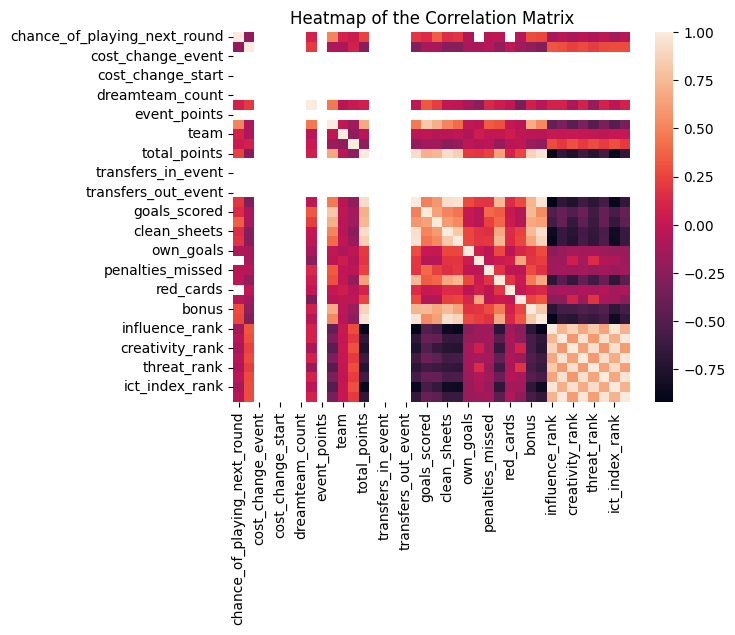

In [11]:
# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=False)

# Set the title for the heatmap
plt.title('Heatmap of the Correlation Matrix')

# Show the heatmap
plt.show()


In [12]:
df.head()

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type
id,,,,,,,,,,,,,,,,,,,,,
1,NaN,None,232223,0,0,0,0,0,4,1.5,...,0.0,0.0,500.0,46.0,499.0,46.0,490.0,48.0,502.0,48.0
2,NaN,None,58822,0,0,0,0,0,2,1.5,...,10.0,11.9,333.0,127.0,287.0,102.0,329.0,126.0,335.0,123.0
3,NaN,None,153256,0,0,0,0,0,3,1.5,...,0.0,1.1,377.0,174.0,347.0,170.0,463.0,183.0,376.0,173.0
4,NaN,None,438098,0,0,0,0,0,3,2.5,...,123.0,41.5,293.0,128.0,163.0,104.0,199.0,113.0,261.0,123.0
5,NaN,None,226597,0,0,0,0,0,2,2.8,...,401.0,127.7,31.0,6.0,196.0,54.0,80.0,3.0,77.0,9.0


In [13]:
df.to_csv(r'C:\Users\mike_\dev\FPL Data Analysis\FPL_env\CSV_Output\df_output.csv')

In [14]:
# Convert cost to millions
df['now_cost_millions'] = df['now_cost'] / 10

In [15]:
df[['second_name','now_cost_millions','now_cost']].sort_values('now_cost')

,second_name,now_cost_millions,now_cost
id,,,
301,Kelleher,4.0,40
169,Franchi,4.0,40
171,McNally,4.0,40
93,Bech Sørensen,4.0,40
438,Biancone,4.0,40
...,...,...,...
396,Rashford,9.0,90
349,De Bruyne,10.5,105
308,Salah,12.5,125


In [16]:
# first: optimal_team

# Initialize the model
model = LpProblem(name="fantasy-football-team-selection", sense=LpMaximize)

# Define the decision variables, excluding players with a chance_of_playing_next_round of 0, 25, or 50
players_to_consider = df[~df['chance_of_playing_next_round'].isin([0, 25, 50])].index
x = LpVariable.dicts('player', players_to_consider, cat='Binary')

# Define the objective function
model += lpSum(df['total_points'][i] * x[i] for i in players_to_consider)

# Define the budget constraint
model += lpSum(df['now_cost_millions'][i] * x[i] for i in players_to_consider) <= 100

# Define the player number constraints
model += lpSum(x[i] for i in players_to_consider) == 15
model += lpSum(x[i] for i in players_to_consider if df['element_type'][i] == 1) == 2
model += lpSum(x[i] for i in players_to_consider if df['element_type'][i] == 2) == 5
model += lpSum(x[i] for i in players_to_consider if df['element_type'][i] == 3) == 5
model += lpSum(x[i] for i in players_to_consider if df['element_type'][i] == 4) == 3

# Define the team constraints
for team in df['team'].unique():
    model += lpSum(x[i] for i in players_to_consider if df['team'][i] == team) <= 3

# Solve the model
status = model.solve()

# Print the status of the solution
print(f"Solution status: {LpStatus[status]}")

# If the model was solved successfully, print the optimal team and save it to a CSV file
if LpStatus[status] == 'Optimal':
    selected_players = [i for i in players_to_consider if x[i].value() == 1]
    optimal_team = df.loc[selected_players]
    print(optimal_team[['first_name', 'second_name', 'now_cost_millions', 'total_points', 'team', 'element_type']])
    optimal_team.to_csv('optimal_team.csv')


Solution status: Optimal
       first_name       second_name  now_cost_millions  total_points  team  \
id                                                                           
12        Gabriel  Martinelli Silva                8.0           198     1   
14         Martin          Ødegaard                8.5           212     1   
29       Benjamin             White                5.5           156     1   
43   Douglas Luiz   Soares de Paulo                5.5           142     2   
51         Tyrone             Mings                4.5           130     2   
60          Ollie           Watkins                8.0           175     2   
109           Ben               Mee                5.0           143     4   
113         David       Raya Martin                5.0           166     4   
134        Pascal              Groß                6.5           159     5   
226      Eberechi               Eze                6.5           159     8   
291       Alisson     Ramses Becker    

In [17]:
optimal_team['total_points'].sum()

2549

In [18]:
optimal_team['now_cost_millions'].sum()

100.0

In [19]:
# second: optimal_team_two



# Initialize the model
model = LpProblem(name="fantasy-football-team-selection-clean-sheets", sense=LpMaximize)

# Define the decision variables, excluding players with a chance_of_playing_next_round of 0, 25, or 50
players_to_consider = df[~df['chance_of_playing_next_round'].isin([0, 25, 50])].index
x = LpVariable.dicts('player', players_to_consider, cat='Binary')

# Define the objective function to maximize clean sheets
model += lpSum(df['clean_sheets'][i] * x[i] for i in players_to_consider)

# Define the budget constraint
model += lpSum(df['now_cost_millions'][i] * x[i] for i in players_to_consider) <= 100

# Define the player number constraints
model += lpSum(x[i] for i in players_to_consider) == 15
model += lpSum(x[i] for i in players_to_consider if df['element_type'][i] == 1) == 2
model += lpSum(x[i] for i in players_to_consider if df['element_type'][i] == 2) == 5
model += lpSum(x[i] for i in players_to_consider if df['element_type'][i] == 3) == 5
model += lpSum(x[i] for i in players_to_consider if df['element_type'][i] == 4) == 3

# Define the team constraints
for team in df['team'].unique():
    model += lpSum(x[i] for i in players_to_consider if df['team'][i] == team) <= 3

# Solve the model
status = model.solve()

# Print the status of the solution
print(f"Solution status: {LpStatus[status]}")

# If the model was solved successfully, print the optimal team and save it to a CSV file
if LpStatus[status] == 'Optimal':
    selected_players = [i for i in players_to_consider if x[i].value() == 1]
    optimal_team_two = df.loc[selected_players]
    print(optimal_team_two[['first_name', 'second_name', 'now_cost_millions', 'clean_sheets', 'team', 'element_type']])
    optimal_team_two.to_csv('optimal_team_two.csv')

Solution status: Optimal
       first_name           second_name  now_cost_millions  clean_sheets  \
id                                                                         
5         Gabriel  dos Santos Magalhães                5.0            14   
17          Aaron              Ramsdale                5.0            14   
29       Benjamin                 White                5.5            15   
43   Douglas Luiz       Soares de Paulo                5.5            13   
51         Tyrone                 Mings                4.5            12   
60          Ollie               Watkins                8.0            13   
85        Dominic               Solanke                6.5             8   
291       Alisson         Ramses Becker                5.5            14   
355        Erling               Haaland               14.0            13   
373         Bruno      Borges Fernandes                8.5            18   
379     Christian               Eriksen                6.0     

In [20]:
optimal_team_two['total_points'].sum()

2335

In [23]:
optimal_team['total_points'].sum()

2549

In [21]:
optimal_team_two['clean_sheets'].sum()

206

In [22]:
optimal_team['clean_sheets'].sum()

189

In [30]:
optimal_team.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'in_dreamteam', 'news',
       'news_added', 'now_cost', 'photo', 'points_per_game', 'second_name',
       'selected_by_percent', 'special', 'squad_number', 'status', 'team',
       'team_code', 'total_points', 'transfers_in', 'transfers_in_event',
       'transfers_out', 'transfers_out_event', 'value_form', 'value_season',
       'web_name', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'influence_rank',
       'influence_rank_type', 'creativity_rank', 'creativity_rank_type',
       'threat_rank', 'thr

In [34]:
optimal_team[['second_name', 'first_name', 'element_type', 'form','team']].sort_values('element_type')

,second_name,first_name,element_type,form,team
id,,,,,
113,Raya Martin,David,1,0.0,4
291,Ramses Becker,Alisson,1,0.0,11
29,White,Benjamin,2,0.0,1
51,Mings,Tyrone,2,0.0,2
109,Mee,Ben,2,0.0,4
407,Burn,Dan,2,0.0,15
430,Trippier,Kieran,2,0.0,15
12,Martinelli Silva,Gabriel,3,0.0,1
14,Ødegaard,Martin,3,0.0,1


In [35]:
optimal_team_two[['second_name', 'first_name', 'element_type', 'form','team']].sort_values('element_type')

,second_name,first_name,element_type,form,team
id,,,,,
17,Ramsdale,Aaron,1,0.0,1
291,Ramses Becker,Alisson,1,0.0,11
5,dos Santos Magalhães,Gabriel,2,0.0,1
29,White,Benjamin,2,0.0,1
51,Mings,Tyrone,2,0.0,2
427,Schär,Fabian,2,0.0,15
430,Trippier,Kieran,2,0.0,15
43,Soares de Paulo,Douglas Luiz,3,0.0,2
373,Borges Fernandes,Bruno,3,0.0,14


In [44]:
df['second_name'][df['team'] == 20]

id
545                   Aït-Nouri
546                     Bentley
547                       Bolla
548                 Bueno López
549              Tomás Oliveira
550                      Cundle
551                      Dawson
552                       Silva
554            Ganchinho Guedes
555                       Hodge
556                      Hoever
557                    Hee-chan
559              Gomes da Silva
560                 Castro Otto
561               Cavaco Jordão
562                   Kalajdzic
563                      Kilman
564                        King
565                      Lemina
566                       Nunes
567                  Lomba Neto
568             Castelo Podence
569              Malheiro de Sá
570                     Sarabia
571                      Šarkić
572               Cabral Semedo
573                       Gomes
574                      Traoré
590    Santos Carneiro Da Cunha
598                     Doherty
Name: second_name, dtype: object